# Premier League Top 6 Predictor

This notebook trains a machine learning model to predict whether a team finishes in the top 6 based on historical data from 2015–2024.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib

sns.set(style="whitegrid")

In [59]:
# Load and prepare data
df = pd.read_csv("processed/league_table.csv")
df["goal_diff"] = df["goals_for"] - df["goals_against"]
df["top_6"] = df["rank"].apply(lambda x: 1 if x <= 6 else 0)

In [60]:
# Sort by team and season to create lagged features
df = df.sort_values(['team', 'season'])

In [61]:
# Create features from previous season
features = ["points", "goal_diff", "goals_for", "goals_against", "wins", "draws", "losses"]
for feature in features:
    df[feature + '_prev'] = df.groupby('team')[feature].shift(1)

In [62]:
# Create target: Top 6 finish in CURRENT season
df['top_6_target'] = df['top_6']

In [63]:
# Drop first season (2015) which has no previous data
df_model = df.dropna(subset=['points_prev']).copy()

In [64]:
# Add additional predictive features
df_model['points_change'] = df_model.groupby('team')['points'].pct_change()
df_model['years_in_league'] = df_model.groupby('team')['season'].transform(lambda x: x.rank(method='dense'))


In [65]:
# Select final features including new ones
features_prev = [f + '_prev' for f in features]
all_features = features_prev + ['points_change', 'years_in_league']

In [66]:
# Split data by season (time-based validation)
train = df_model[df_model['season'] < 2024]  # 2016-2023
test = df_model[df_model['season'] == 2024]   # Validation on 2024


In [67]:

X_train = train[all_features]
y_train = train['top_6_target']
X_test = test[all_features]
y_test = test['top_6_target']


In [68]:
# Train model with class balancing
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=200,
                       random_state=42)

In [69]:
# Evaluate model
y_pred = model.predict(X_test)
print("Validation Report (2024 season):")
print(classification_report(y_test, y_pred))

Validation Report (2024 season):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         6

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



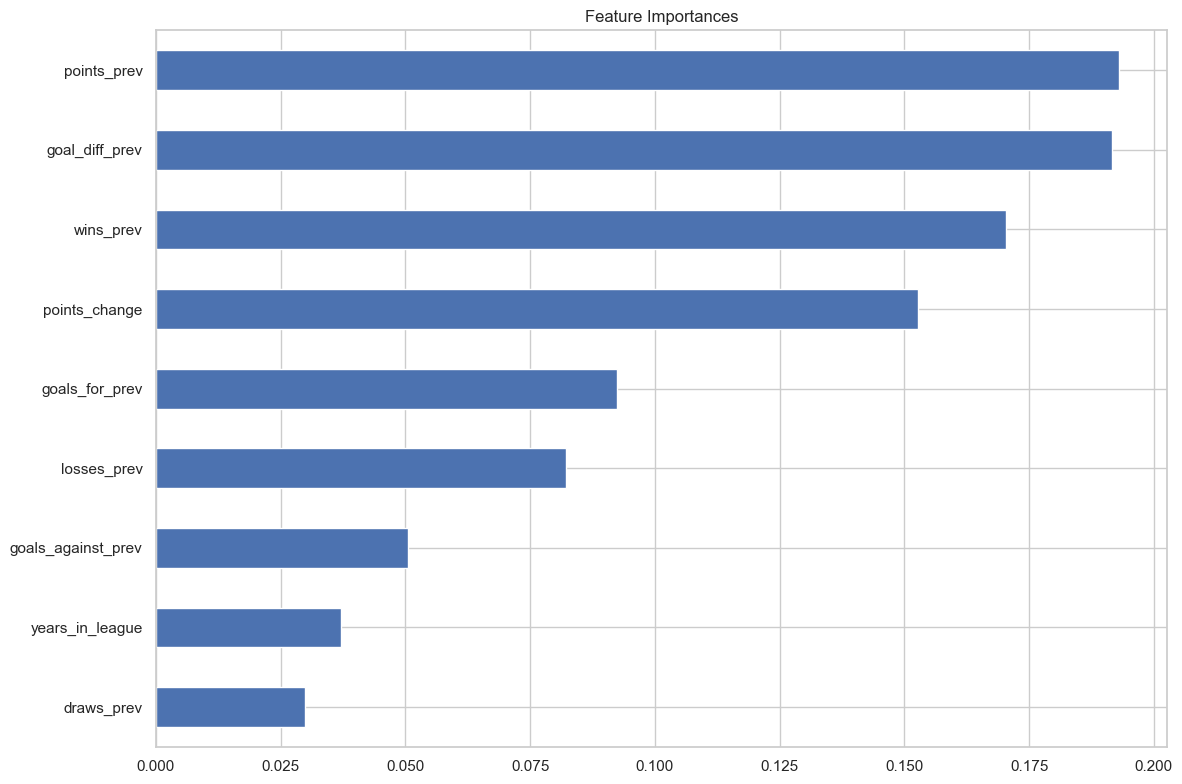

In [70]:
# Plot feature importance
feature_importances = pd.Series(model.feature_importances_, index=all_features)
plt.figure(figsize=(12, 8))
feature_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


# --- Predict 2025-2026 Top 6 ---

In [71]:
latest_season = df[df['season'] == 2024].copy()

In [72]:
# 2. Remove relegated teams (bottom 3)
latest_season = latest_season[latest_season['rank'] <= 17]

In [76]:
# 3. Prepare prediction data for NEXT season (2025)
pred_data = latest_season.copy()
# Calculate years in league correctly (continuous count)
team_season_counts = df[df['season'] <= 2024].groupby('team')['season'].nunique()
pred_data['years_in_league'] = pred_data['team'].map(team_season_counts).fillna(1).astype(int)

# Calculate points change relative to 2023
for team in pred_data['team']:
    team_data = df[(df['team'] == team) & (df['season'].between(2023, 2024))]
    if len(team_data) == 2:
        prev_points = team_data[team_data['season'] == 2023]['points'].values[0]
        current_points = team_data[team_data['season'] == 2024]['points'].values[0]
        pred_data.loc[pred_data['team'] == team, 'points_change'] = (current_points - prev_points) / prev_points
    else:
        # For teams missing 2023 data (newly promoted)
        pred_data.loc[pred_data['team'] == team, 'points_change'] = 0  # Neutral change

# Set previous season features (2024 stats become "previous" for 2025)
for feature in features:
    pred_data[feature + '_prev'] = pred_data[feature]

In [77]:

# 4. Predict probabilities
pred_data['top_6_prob_2025'] = model.predict_proba(pred_data[all_features])[:, 1]

In [78]:
# 5. Get top 6 predictions
top6_2025 = (pred_data.sort_values('top_6_prob_2025', ascending=False)
             .head(6)[['team', 'points', 'goal_diff', 'top_6_prob_2025']])

print("\nPredicted Top 6 for 2025-2026 Season:")
print(top6_2025.to_string(index=False))


Predicted Top 6 for 2025-2026 Season:
             team  points  goal_diff  top_6_prob_2025
        Liverpool      84         45         0.935000
Nottingham Forest      65         12         0.844537
          Chelsea      69         21         0.824537
        Newcastle      66         21         0.784304
      Aston Villa      66          7         0.750000
         Brighton      61          7         0.706735


In [80]:
# 6. Save predictions
top6_2025.to_csv("processed/predicted_top6_2025.csv", index=False)

In [81]:
# 7. Retrain model on all data and save
final_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',
    random_state=42
)
final_model.fit(df_model[all_features], df_model['top_6_target'])
joblib.dump(final_model, "processed/top6_model.pkl")

['processed/top6_model.pkl']